In [1]:
#!/usr/bin/env python3
#pip install  rioxarray==0.3.1
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray
import numpy as np
import geopandas as gpd
import cartopy.crs as ccrs
import rasterio
import os
import matplotlib.colors
scriptsdir = os.getcwd()
from scipy.interpolate import griddata
from functools import reduce
import xarray
import itertools
import argparse
import matplotlib.colors as mcolors

In [2]:
models=["GAM"]
taxas=["Mammals"]

In [5]:


model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
years = ['1845', '1990', '1995', '2009', '2010', '2020', '2026', '2032', '2048', '2050',
         '2052', '2056', '2080', '2100', '2150', '2200', '2250']

for taxa in taxas:
    for model in models:
        dir_species = "/storage/scratch/users/ch21o450/data/LandClim_Output/" + model + "/" + taxa + "/EWEMBI/"
        available_file = os.listdir(dir_species)
        available_names = [x.split("_[1146].nc")[0] for x in available_file]

species_names = available_names[:100]
#newvalue
for taxa in taxas:
    for model in models:
        def calculate_extinct_species(time, model, netcdf_path_format, is_historical=False, scenario=None):
            sum_bin_dict = {model_name: {} for model_name in model_names}

            for model_name in model_names:
                for species_name in species_names:
                    if is_historical:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, species_name, time), decode_times=False)
                    else:
                        ds = xr.open_dataset(netcdf_path_format.format(model, taxa, model_name, scenario, species_name, time), decode_times=False)
                    sum_bin = ds["sum_bin"]

                    sum_bin_dict[model_name][species_name] = sum_bin

            extinct_species_dict = {}

            for species_name in species_names:
                extinct_species_list = []
                for model_name in model_names:
                    sum_bin = sum_bin_dict[model_name][species_name]
                    # count if sum_bin becomes zero, which represents extinct species
                    extinct_species = (sum_bin == 0).sum().item()
                    extinct_species_list.append(extinct_species)
                extinct_species_total = sum(extinct_species_list)
                extinct_species_dict[species_name] = extinct_species_total

            return extinct_species_dict


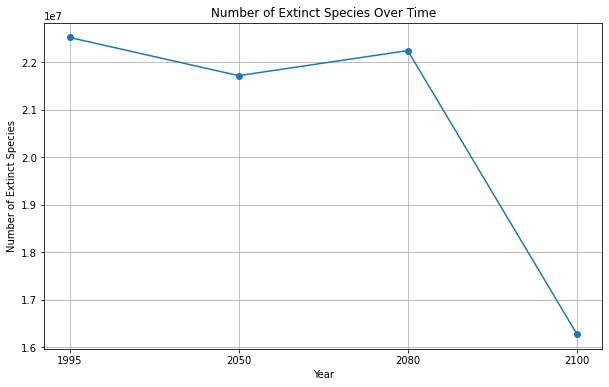

In [6]:
import matplotlib.pyplot as plt

historical_time = 1146
future_times = [35, 65, 85]

model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
netcdf_path_format_future = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/{}/{}/{}_[{}].nc"
netcdf_path_format_hist = "/storage/scratch/users/ch21o450/data/LandClim_Output/{}/{}/EWEMBI/{}_[{}].nc"
year_indices = {1146: '1995', 35: '2050', 65: '2080', 85: '2100'}
# Create a dictionary to store extinct species count for each time period
extinct_species_count = {}

for taxa in taxas:
    for model in models:
        # Modify the following line to call the new calculate_extinct_species function
        extinct_species_dict = calculate_extinct_species(historical_time, model, netcdf_path_format_hist, is_historical=True)
        extinct_species_count[year_indices[historical_time]] = sum(extinct_species_dict.values())

        for future_time in future_times:
            if future_time == 35 or future_time == 65:
                model_names = ['GFDL-ESM2M', 'IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26","rcp60"]
            elif future_time == 85:
                model_names = ['IPSL-CM5A-LR', 'HadGEM2-ES', 'MIROC5']
                scenarios = ["rcp26"]

            for scenario in scenarios:
                # Modify the following line to call the new calculate_extinct_species function
                extinct_species_dict = calculate_extinct_species(future_time, model, netcdf_path_format_future, is_historical=False, scenario=scenario)
                extinct_species_count[year_indices[future_time]] = sum(extinct_species_dict.values())

# Plot the number of extinct species over time
plt.figure(figsize=(10, 6))
plt.plot(list(extinct_species_count.keys()), list(extinct_species_count.values()), marker='o')
plt.xlabel('Year')
plt.ylabel('Number of Extinct Species')
plt.title('Number of Extinct Species Over Time')
plt.grid(True)
plt.show()
